In [17]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras import Sequential, Model
from IPython.display import display

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

from transformers import TFCamembertModel, CamembertTokenizer, CamembertConfig
# config = CamembertConfig.from_pretrained("camembert-base", output_hidden_states=False)
# camembert = TFCamembertModel.from_pretrained("camembert-base", config=config)
camembert = TFCamembertModel.from_pretrained("camembert-base")
tokenizer = CamembertTokenizer.from_pretrained("camembert-base")

from matplotlib import pyplot as plt

Some layers from the model checkpoint at camembert-base were not used when initializing TFCamembertModel: ['lm_head']
- This IS expected if you are initializing TFCamembertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFCamembertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFCamembertModel were not initialized from the model checkpoint at camembert-base and are newly initialized: ['roberta/pooler/dense/bias:0', 'roberta/pooler/dense/kernel:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:

# TODO :
# faire une base d'evaluation en plus de train et test
# implementer un systeme d'epoch complet avec tf.dataset
# ajouter les données non supervisées au discriminateur => extraction des feature des texte non labelisé à faire
# annulation de la loss du label parametrable (lors de l'utilisation des data non supervisé), faisable en ajoutant des boolean au discriminateur faisant office de mask
# Masking loss : https://stackoverflow.com/questions/64130293/custom-loss-function-in-keras-with-masking-array-as-input

#multi output loss https://datascience.stackexchange.com/questions/86700/custom-loss-function-with-multiple-outputs-in-tensorflow

# https://ledatascientist.com/analyse-de-sentiments-avec-camembert/
# https://ledatascientist.com/introduction-a-la-categorisation-de-textes/
# https://www.kaggle.com/houssemayed/camembert-for-french-tweets-classification
# https://lbourdois.github.io/blog/nlp/BERT/


Definition des models

In [19]:
class CustomCamemBERT(tf.keras.Model):
	def __init__(self, camembert, tokenizer):
		super().__init__()
		self.tokenizer = tokenizer
		self.cam = camembert
		self.GAP = GlobalAveragePooling1D()
		# self.GAP = Flatten()

	def call(self, inputs):
		l = tf.reshape(tf.convert_to_tensor(()), (0, 768 * 1))
		for sentence in inputs:
			# print("\nSentence:", sentence)
			tokenized = tokenizer.tokenize(sentence)
			# print(tokenized)
			encoded_sentence = tf.constant([tokenizer.encode(tokenized)], dtype=tf.int32)
			# print("Sentence encoded:", encoded_sentence.numpy())
			x = self.cam(encoded_sentence).last_hidden_state
			# print(x.shape)
			x = x[:,0,:]
			# x = self.GAP(x)
			# x = tf.reduce_mean(x, axis=1)
			# print("x", x)
			l = tf.concat([l, x], 0)
		# print("l", l)
		return l

# tokenized_sentence = tokenizer.tokenize("J'aime le camembert !")
# encoded_sentence = tf.constant([tokenizer.encode(tokenizer.tokenize("J'aime le camembert !"))], dtype=tf.int32)
# print(encoded_sentence)
# camembert(encoded_sentence)

NLP_model = CustomCamemBERT(camembert, tokenizer)
NLP_model.trainable = False

# display(model("J'aime le camembert !"))
features = NLP_model(["J'adore le fromage", "J'aime le fromage", "J'aime pas le fromage", "Je déteste le fromage"])
# features = NLP_model(["femme", "homme", "roi", "renne"])
features = features.numpy()
display(features)
# TODO : tester le distance de ces deux vecteurs avec 2 autre "je deteste le camenbert" et "j'adore le camenbert"

array([[-0.00506864,  0.03288577,  0.10317481, ..., -0.11409686,
        -0.0644333 , -0.04663153],
       [-0.00957023,  0.01769341,  0.11609352, ..., -0.12855044,
        -0.06759973, -0.05530701],
       [-0.01601247,  0.00745936,  0.09931052, ..., -0.11751904,
        -0.03361285, -0.02913235],
       [ 0.03644988,  0.03005837,  0.13093765, ..., -0.08100408,
        -0.03284521, -0.09860273]], dtype=float32)

In [20]:
features.shape
# for i in range(len(features)):
# 	display(np.sqrt(np.sum((features[1] - features[i]) ** 2)))

np.sqrt(np.sum((features[:, np.newaxis, :] - features[np.newaxis, :, :]) ** 2, axis = -1))

array([[0.       , 0.2681543, 0.4545043, 1.2075024],
       [0.2681543, 0.       , 0.3993235, 1.2603542],
       [0.4545043, 0.3993235, 0.       , 1.3251797],
       [1.2075024, 1.2603542, 1.3251797, 0.       ]], dtype=float32)

1. Préparation des données et feature extraction

In [21]:
if(os.path.isfile('./featured.csv')):
    sup = np.genfromtxt('featured.csv', delimiter=',')
else:
    sup = pd.read_csv("./supervise.csv")[["text", "label_shufan"]]
    features = NLP_model(sup[["text"]].to_numpy().reshape(-1,).tolist())
    features = features.numpy()
    labels = np.array([sup["label_shufan"]]).T
    sup = np.concatenate([labels, features], axis=1)
    np.savetxt('featured.csv', sup, delimiter=",")


In [22]:
sup.shape

(244, 769)

In [23]:
np.savetxt('featured.csv', sup, delimiter=",")

In [24]:
def generate_noise(n_batch, latent_dim):
    	return np.random.randn(latent_dim * n_batch).reshape((n_batch, latent_dim))
 
def generate_fake_samples(n_batch, labelN, generator, latent_dim):
	labels = np.repeat(labelN, n_batch)
	X_fake = generator([generate_noise(n_batch, latent_dim), labels])
	y_fake = np.array([labels, np.repeat(0, n_batch)]).reshape(2, n_batch).T
	return X_fake, y_fake

def select_real_samples(n_batch, labelN, dataset):
	dataset = dataset[dataset[:, 0] == labelN, :]
	ind = np.random.choice(len(dataset), size=n_batch, replace=False)
	labels = np.repeat(labelN, n_batch)
	X_real = np.array(dataset[ind, 1:].tolist())
	y_real =  np.array([labels, np.repeat(1, n_batch)]).reshape(2, n_batch).T
	return X_real, y_real

def train_d(discriminator, dataset, n_batch):
	# (n_batch, 768), ([label, validité])
	X_fake, y_fake = generate_fake_samples(n_batch, 0, generator=G, latent_dim=100)
	d_fake_0 = discriminator.train_on_batch(X_fake, y_fake)

	X_fake, y_fake = generate_fake_samples(n_batch, 1, generator=G, latent_dim=100)
	d_fake_1 = discriminator.train_on_batch(X_fake, y_fake)

	X_real, y_real = select_real_samples(n_batch, 0, dataset=dataset)
	d_real_0 = discriminator.train_on_batch(X_real, y_real)

	X_real, y_real = select_real_samples(n_batch, 1, dataset=dataset)
	d_real_1 = discriminator.train_on_batch(X_real, y_real)

	return (1 / 4) * (d_fake_0[0] + d_fake_1[0] + d_real_0[0] + d_real_1[0])

def train_g(gan, n_batch):
	labels = np.repeat(1, n_batch)
	noise = generate_noise(n_batch, latent_dim)
	g_loss_1 = gan.train_on_batch([noise, labels], np.array([labels, np.repeat(1, n_batch)]).reshape(2, n_batch).T)

	labels = np.repeat(0, n_batch)
	noise = generate_noise(n_batch, latent_dim)
	g_loss_0 = gan.train_on_batch([noise, labels], np.array([labels, np.repeat(1, n_batch)]).reshape(2, n_batch).T)

	return (1 / 2) * (g_loss_1[0] + g_loss_0[0])

In [25]:
sup_train = np.concatenate([sup[sup[:,0] == 1][0:19], sup[sup[:,0] == 0][0:19]])
sup_test  = np.concatenate([sup[sup[:,0] == 1][19:38], sup[sup[:,0] == 0][19:38]])
sup_test.shape, sup_train.shape
sup_test[:,0]
sup_train[:,0]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0.])

In [369]:
tf.config.run_functions_eagerly(False)

@tf.function
def label_acc(y_true, y_pred): return  tf.keras.metrics.binary_accuracy(y_true[:,0], y_pred[:,0])

@tf.function
def reality_acc(y_true, y_pred): return tf.keras.metrics.binary_accuracy(y_true[:,1], y_pred[:,1])

@tf.function
def label_acc_g(y_true, y_pred): return  tf.keras.metrics.binary_accuracy(y_true[:,0], 1 - y_pred[:,0]) #

@tf.function
def reality_acc_g(y_true, y_pred): return tf.keras.metrics.binary_accuracy(y_true[:,1], 1 - y_pred[:,1])

@tf.function
def label_loss(y_true, y_pred): return tf.keras.losses.binary_crossentropy(y_true[:,0], y_pred[:,0])

@tf.function
def reality_loss(y_true, y_pred): return tf.keras.losses.binary_crossentropy(y_true[:,1], y_pred[:,1])

@tf.function
def label_loss_g(y_true, y_pred): return tf.keras.losses.binary_crossentropy(y_true[:,0], 1 - y_pred[:,0]) #

@tf.function
def reality_loss_g(y_true, y_pred): return tf.keras.losses.binary_crossentropy(y_true[:,1], 1 - y_pred[:,1])

@tf.function
def discriminator_loss(y_true, y_pred):
	l_loss_p = 0.75
	loss_l = label_loss(y_true, y_pred)
	loss_r = reality_loss(y_true, y_pred)
	return ( l_loss_p * loss_l ) + ( (1 - l_loss_p) * loss_r )

@tf.function
def generator_loss(y_true, y_pred):
	l_loss_p = 0.25
	loss_l = label_loss(y_true, 1 - y_pred)
	loss_r = reality_loss(y_true, 1 - y_pred)
	return ( l_loss_p * loss_l ) + ( (1 - l_loss_p) * loss_r )

In [370]:
def generator(latent_dim):
	noise = Input(shape=(latent_dim,), name="noise_input", dtype=tf.float32)
	label = Input(shape=(1,), name="label_input", dtype=tf.float32) 

	label_embedding = Flatten()(Embedding(2, latent_dim, name="label_embeding")(label))
	model_input = Multiply(name="mult_label_noise")([noise, label_embedding])

	x = Dense(256, input_dim=latent_dim)(model_input)
	x = Dropout(0.2)(x)
	x = Dense(512, input_dim=latent_dim)(x)
	out = Dense(768, kernel_initializer="random_uniform", name="Generated_Hidden_rep")(x)

	return Model([noise, label], out, name="Generator")

def discriminator():
	hidden_rep = Input(shape=(768,), dtype=tf.float32, name="Hidden_rep_Input")
	x = Dense(256)(hidden_rep)
	x = Dropout(0.2)(x)
	x = Dense(128)(x)
	out = Dense(2, name="Prediction", activation="sigmoid")(x)    

	return Model(hidden_rep, out, name="Discriminator")


D = discriminator()
D.compile(loss=discriminator_loss, metrics=[label_loss, reality_loss, label_acc, reality_acc], optimizer=tf.keras.optimizers.SGD(learning_rate=0.001))
D.trainable = False

latent_dim = 100
G = generator(latent_dim)
G.compile()

noise = Input(shape=(latent_dim,))
label = Input(shape=(1,))
hidden_rep = G([noise, label])
validity = D(hidden_rep)

GAN = Model([noise, label], validity, name="GAN")
GAN.compile(loss=generator_loss, metrics=[label_loss_g, reality_loss_g, label_acc_g, reality_acc_g], optimizer=tf.keras.optimizers.SGD(learning_rate=0.001))

hist = []

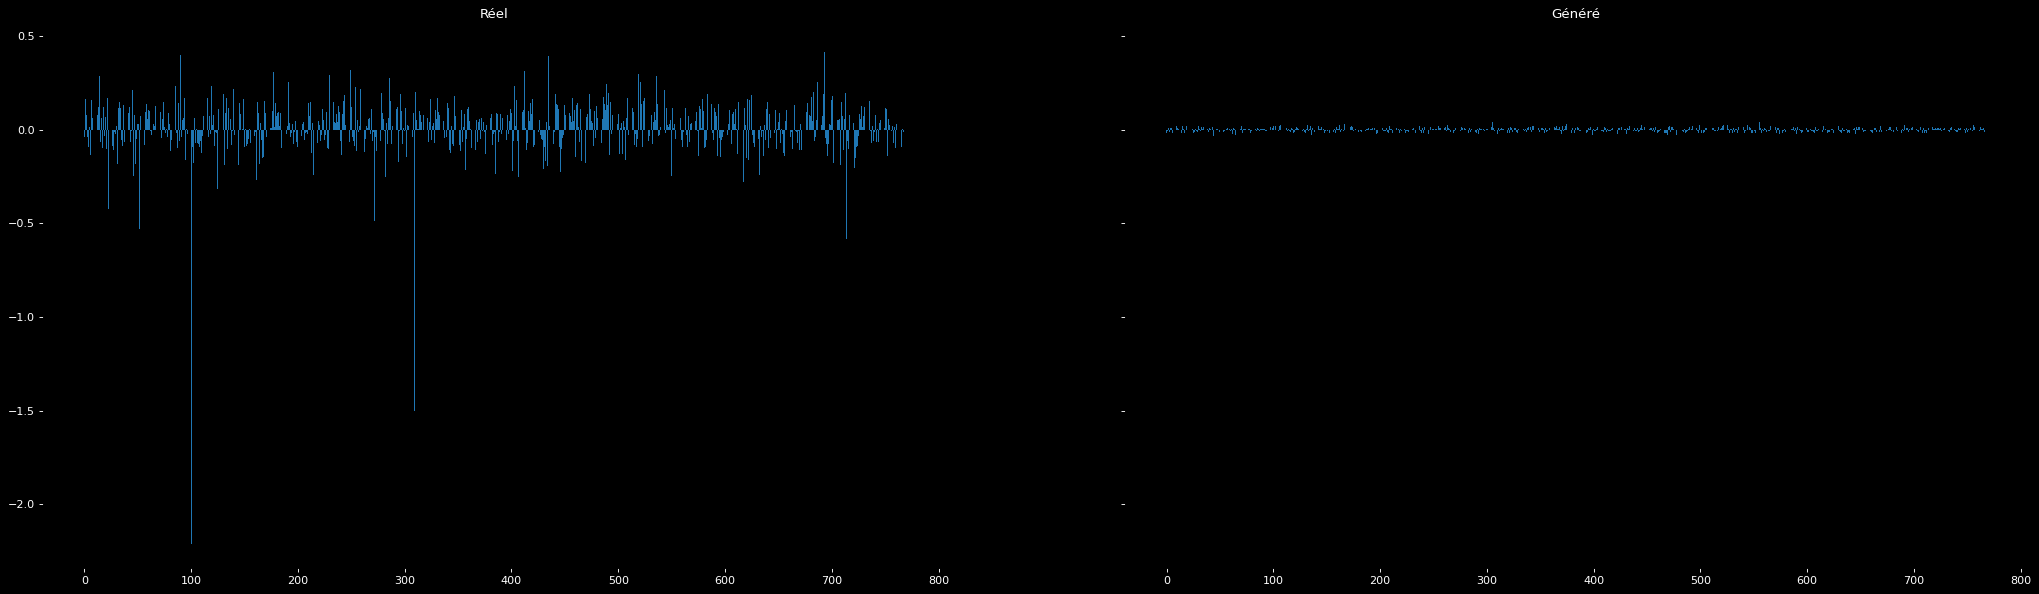

In [371]:
l = np.repeat(1, 1)
n = generate_noise(1, latent_dim)
pred_avant = G.predict([n, l])

fig, axs = plt.subplots(1, 2, sharey=True, figsize=(16*2, 9), dpi=80)
axs[0].bar(range(768), sup[24,1:])
axs[0].set(title='Réel')
axs[1].bar(range(768), pred_avant[0])
axs[1].set(title='Généré')
plt.show()

In [372]:
epochs = 200
n_batch = 8

glabels = np.concatenate([np.repeat(1, 10), np.repeat(0, 10)])
gnoise = generate_noise(20, latent_dim)
gY = np.array([glabels, np.repeat(1, 20)]).reshape(2, 20).T
gX = [gnoise, glabels]

X_train = sup_train[:,1:]
labels_train = np.array(sup_train[:,0], dtype=np.float32)
realite_train = np.ones((len(labels_train),), dtype=np.float32)
y_train = np.array([labels_train, realite_train]).T

X_test = sup_test[:,1:]
labels_test = np.array(sup_test[:,0], dtype=np.float32)
realite_test = np.ones((len(labels_test),), dtype=np.float32)
y_test = np.array([labels_test, realite_test]).T

for e in range(epochs):
	d_loss = train_d(D, sup_train, n_batch)
	g_loss = train_g(GAN, n_batch * 1)
	
	train_loss = D.evaluate(X_train, y_train, verbose=0)
	test_loss = D.evaluate(X_test, y_test, verbose=0)

	geval = GAN.evaluate(gX, gY, verbose=0)
	deval = D.evaluate(G.predict(gX), gY, verbose=0)
	
	hist.append([d_loss, g_loss, *train_loss, *test_loss, *geval, *deval])
	print(e, [np.round(g_loss, 2), np.round(d_loss, 2), np.round(train_loss, 2), np.round(test_loss, 2), np.round(geval, 2), np.round(deval, 2)])

0 [0.69, 0.75, array([0.74, 0.77, 0.88, 0.3 , 0.  ]), array([0.74, 0.77, 0.89, 0.31, 0.  ]), array([0.69, 0.69, 0.69, 0.4 , 0.7 ]), array([0.69, 0.69, 0.7 , 0.6 , 0.3 ])]
1 [0.69, 0.72, array([0.74, 0.77, 0.87, 0.3 , 0.  ]), array([0.74, 0.76, 0.88, 0.31, 0.  ]), array([0.69, 0.69, 0.69, 0.4 , 0.75]), array([0.69, 0.69, 0.7 , 0.6 , 0.25])]
2 [0.69, 0.71, array([0.74, 0.76, 0.86, 0.3 , 0.  ]), array([0.74, 0.76, 0.87, 0.31, 0.  ]), array([0.69, 0.69, 0.69, 0.4 , 0.8 ]), array([0.69, 0.69, 0.7 , 0.6 , 0.2 ])]
3 [0.68, 0.71, array([0.73, 0.76, 0.85, 0.3 , 0.  ]), array([0.73, 0.76, 0.86, 0.31, 0.  ]), array([0.69, 0.69, 0.68, 0.4 , 0.8 ]), array([0.7 , 0.69, 0.7 , 0.6 , 0.2 ])]
4 [0.69, 0.71, array([0.73, 0.76, 0.84, 0.3 , 0.  ]), array([0.73, 0.75, 0.85, 0.31, 0.  ]), array([0.69, 0.69, 0.68, 0.4 , 0.95]), array([0.7 , 0.69, 0.7 , 0.6 , 0.05])]
5 [0.68, 0.71, array([0.73, 0.75, 0.83, 0.3 , 0.  ]), array([0.73, 0.75, 0.84, 0.31, 0.  ]), array([0.68, 0.69, 0.68, 0.45, 1.  ]), array([0.7 , 

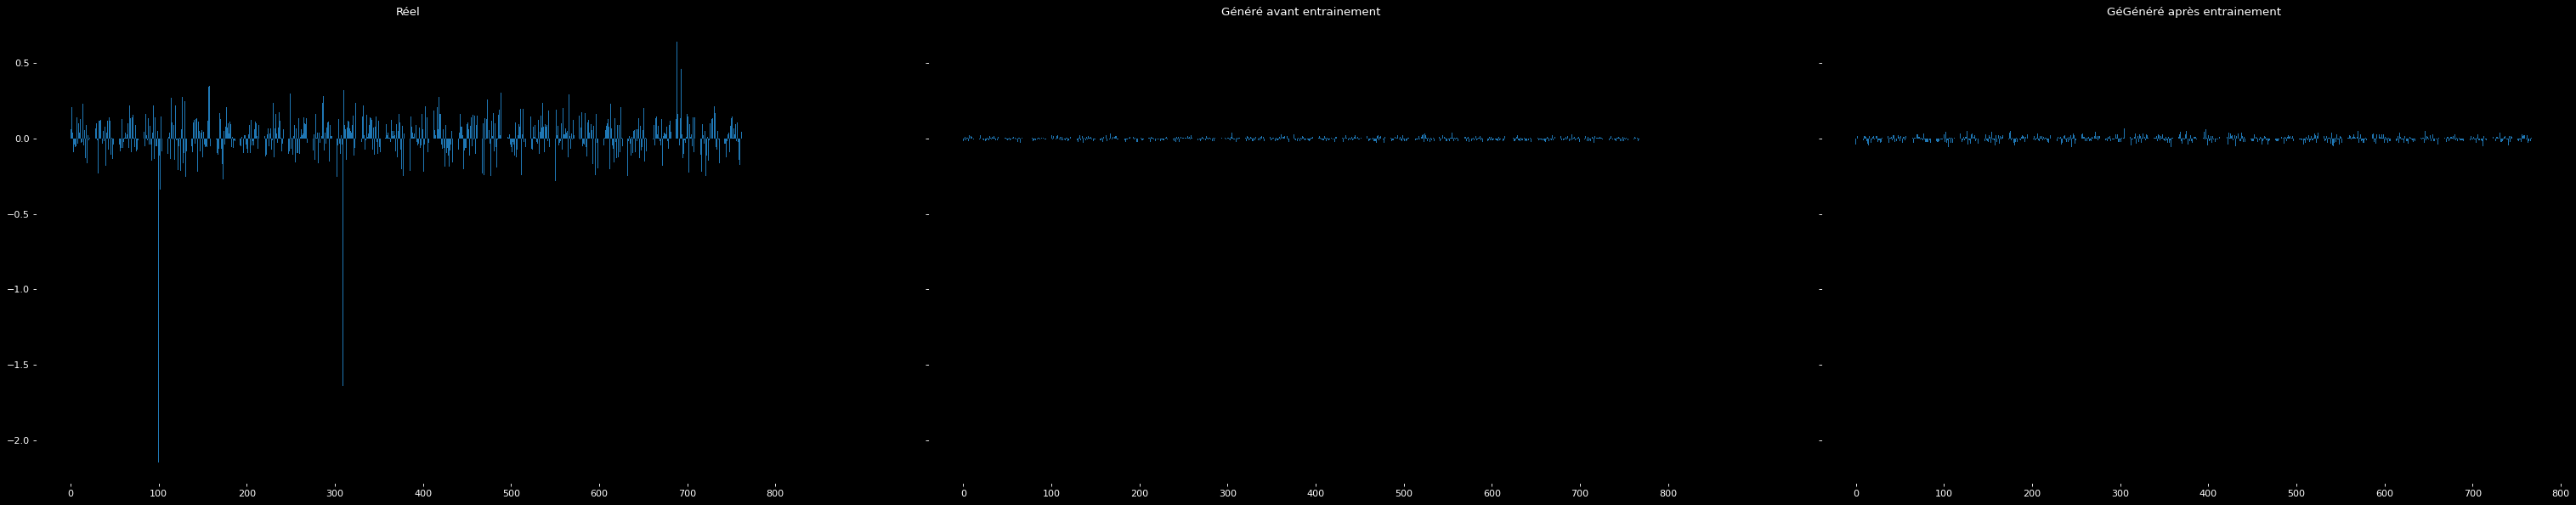

In [373]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(16*3, 9), dpi=80)
pred_apres = G.predict([n, l])
axs[0].bar(range(768), sup[2,1:])
axs[0].set(title='Réel')
axs[1].bar(range(768), pred_avant[0])
axs[1].set(title='Généré avant entrainement')
axs[2].bar(range(768), pred_apres[0])
axs[2].set(title='GéGénéré après entrainement')
plt.show()

pour evaluer on reprend la base de donné supervisé, on ballance les feature au discriminateur sans les label et on regarde s'il trouve les meme label et qu'il dit qu'il sont des donné reel (cad données non générées)

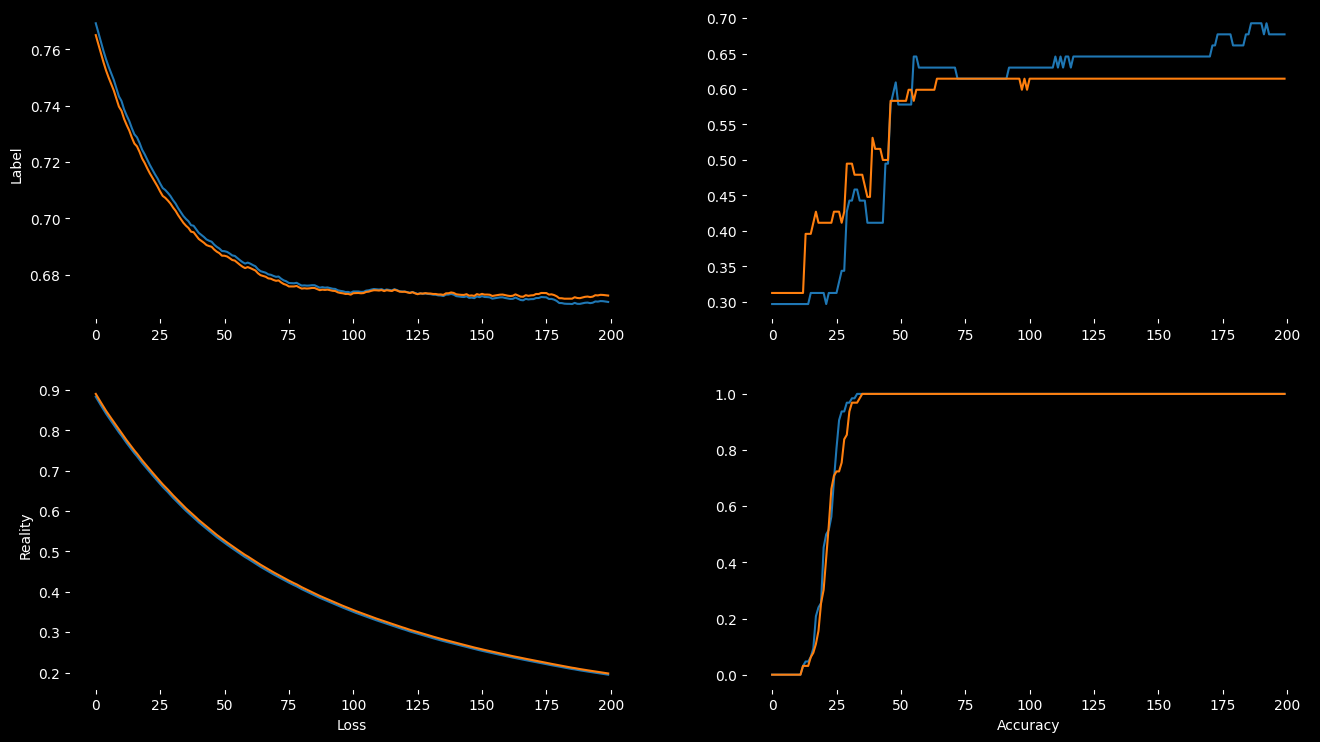

In [374]:
histnp = np.asarray(hist)
plt.rcParams['axes.facecolor'] = 'black'
plt.rcParams['figure.facecolor'] = 'black'
COLOR = 'white'
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR

w, h = 16, 9
fig, axs = plt.subplots(2, 2, figsize=(w, h), dpi=100)
axs[0, 0].plot(histnp[:,[3,3+5]])
axs[0, 0].set(ylabel='Label')

axs[1, 0].plot(histnp[:,[4,4+5]])
axs[1, 0].set(ylabel='Reality', xlabel='Loss')

axs[0, 1].plot(histnp[:,[5,5+5]])

axs[1, 1].plot(histnp[:,[6,6+5]])
axs[1, 1].set(xlabel='Accuracy')

plt.show()

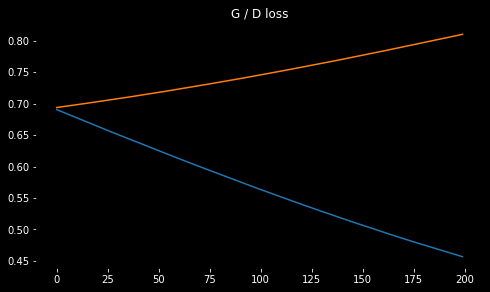

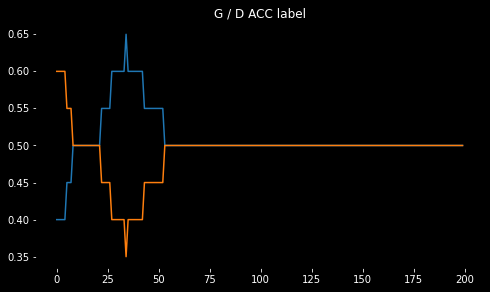

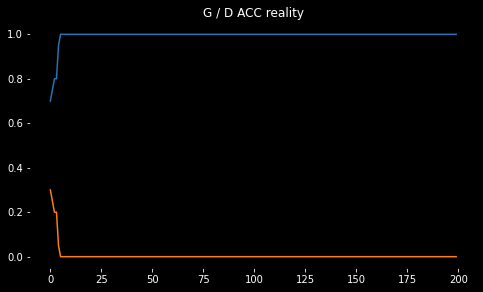

In [375]:
histnp = np.asarray(hist)
w, h = 8, 9/2

plt.figure(figsize=(w, h))
plt.title("G / D loss")
plt.plot(histnp[:,[12, 17]])
plt.show()


plt.figure(figsize=(w, h))
plt.title("G / D ACC label")
plt.plot(histnp[:,[15, 20]])
plt.show()

plt.figure(figsize=(w, h))
plt.title("G / D ACC reality")
plt.plot(histnp[:,[16, 21]])
plt.show()


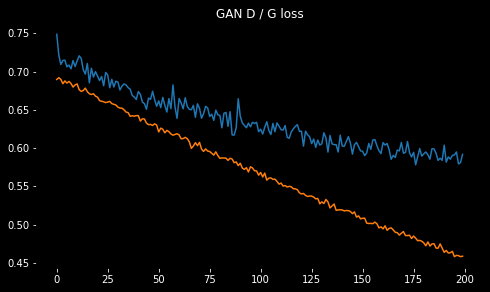

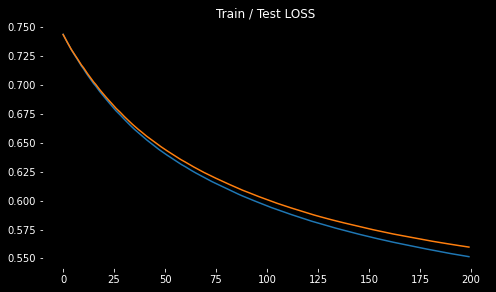

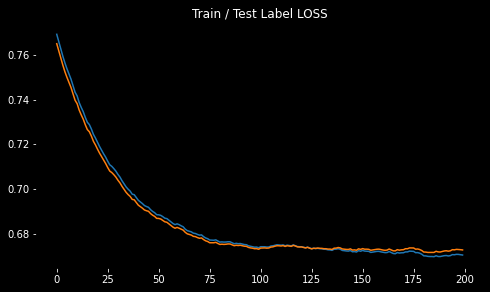

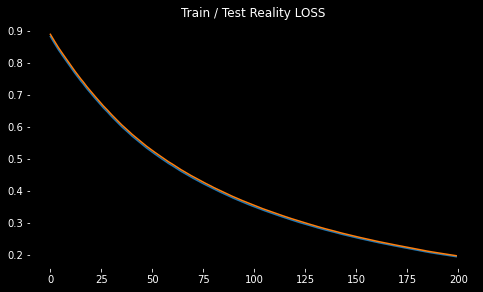

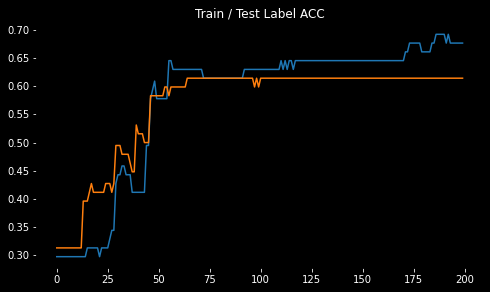

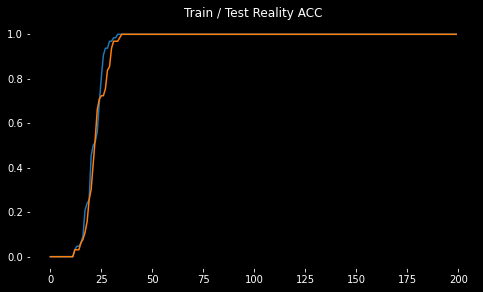

In [376]:
histnp = np.asarray(hist)
plt.rcParams['axes.facecolor'] = 'black'
plt.rcParams['figure.facecolor'] = 'black'
COLOR = 'white'
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR

w, h = 8, 9/2
plt.figure(figsize=(w, h))
plt.title("GAN D / G loss")
plt.plot(histnp[:,0:2])
plt.show()

plt.figure(figsize=(w, h))
plt.title("Train / Test LOSS")
plt.plot(histnp[:,[2,2+5]])
plt.show()

plt.figure(figsize=(w, h))
plt.title("Train / Test Label LOSS")
plt.plot(histnp[:,[3,3+5]])
plt.show()

plt.figure(figsize=(w, h))
plt.title("Train / Test Reality LOSS")
plt.plot(histnp[:,[4,4+5]])
plt.show()

plt.figure(figsize=(w, h))
plt.title("Train / Test Label ACC")
plt.plot(histnp[:,[5,5+5]])
plt.show()

plt.figure(figsize=(w, h))
plt.title("Train / Test Reality ACC")
plt.plot(histnp[:,[6,6+5]])
plt.show()


In [377]:
X = np.array(sup_train[:,1:].tolist())
labels = sup_train[:,0]
realite = np.ones((len(labels),))
display(np.array([labels, D(X)[:,0]]).T)
display(np.array([realite, D(X)[:,1]]).T)
display(D.evaluate(X, np.array([labels, realite], dtype=np.float32).T))

array([[1.        , 0.49461916],
       [1.        , 0.4925057 ],
       [1.        , 0.45230833],
       [1.        , 0.48852071],
       [1.        , 0.56749916],
       [1.        , 0.50330931],
       [1.        , 0.50763649],
       [1.        , 0.50754285],
       [1.        , 0.50894582],
       [1.        , 0.50707507],
       [1.        , 0.48504525],
       [1.        , 0.53876173],
       [1.        , 0.48857772],
       [1.        , 0.47722676],
       [1.        , 0.5199514 ],
       [1.        , 0.48796207],
       [1.        , 0.52015364],
       [1.        , 0.50377494],
       [1.        , 0.5208317 ],
       [0.        , 0.48878247],
       [0.        , 0.4803265 ],
       [0.        , 0.44581181],
       [0.        , 0.4609471 ],
       [0.        , 0.47122142],
       [0.        , 0.5005607 ],
       [0.        , 0.49626788],
       [0.        , 0.479067  ],
       [0.        , 0.46307799],
       [0.        , 0.44155684],
       [0.        , 0.5322842 ],
       [0.

array([[1.        , 0.7910682 ],
       [1.        , 0.82871294],
       [1.        , 0.81638086],
       [1.        , 0.8110655 ],
       [1.        , 0.81303549],
       [1.        , 0.82766676],
       [1.        , 0.83131552],
       [1.        , 0.83321398],
       [1.        , 0.81829202],
       [1.        , 0.82579195],
       [1.        , 0.82645345],
       [1.        , 0.80543673],
       [1.        , 0.81460196],
       [1.        , 0.82120335],
       [1.        , 0.82068992],
       [1.        , 0.83630073],
       [1.        , 0.80535853],
       [1.        , 0.84726954],
       [1.        , 0.82575679],
       [1.        , 0.82304227],
       [1.        , 0.82113045],
       [1.        , 0.83066732],
       [1.        , 0.82927746],
       [1.        , 0.80614722],
       [1.        , 0.83410132],
       [1.        , 0.82175195],
       [1.        , 0.8357622 ],
       [1.        , 0.84922314],
       [1.        , 0.83701098],
       [1.        , 0.84063864],
       [1.

2/2 [==============================] - 0s 3ms/step - loss: 0.5515 - label_loss: 0.6704 - reality_loss: 0.1947 - label_acc: 0.6771 - reality_acc: 1.0000


[0.5515352487564087,
 0.6704088449478149,
 0.19473803043365479,
 0.6770833730697632,
 1.0]

In [34]:
X = np.array(sup_test[:,1:].tolist())
labels = sup_test[:,0]
realite = np.ones((len(labels),))
display(np.array([labels, D(X)[:,0]]).T)
display(np.array([realite, D(X)[:,1]]).T)
display(D.evaluate(X, np.array([labels, realite], dtype=np.float32).T))

array([[1.        , 0.72626835],
       [1.        , 0.44963086],
       [1.        , 0.60036039],
       [1.        , 0.87133479],
       [1.        , 0.52685094],
       [1.        , 0.34519351],
       [1.        , 0.98107052],
       [1.        , 0.8644079 ],
       [1.        , 0.83638489],
       [1.        , 0.69847691],
       [1.        , 0.76982546],
       [1.        , 0.1033698 ],
       [1.        , 0.21096343],
       [1.        , 0.81415439],
       [1.        , 0.92946821],
       [1.        , 0.30692199],
       [1.        , 0.84654844],
       [1.        , 0.33420157],
       [1.        , 0.92926943],
       [0.        , 0.39334381],
       [0.        , 0.69143164],
       [0.        , 0.106592  ],
       [0.        , 0.12557456],
       [0.        , 0.24882525],
       [0.        , 0.09080958],
       [0.        , 0.32625967],
       [0.        , 0.88697946],
       [0.        , 0.19438547],
       [0.        , 0.89138424],
       [0.        , 0.72419912],
       [0.

array([[1.        , 0.99998379],
       [1.        , 0.99997354],
       [1.        , 0.99994028],
       [1.        , 0.99997669],
       [1.        , 0.99997973],
       [1.        , 0.99997568],
       [1.        , 0.99993575],
       [1.        , 0.9999541 ],
       [1.        , 0.99997896],
       [1.        , 0.99997962],
       [1.        , 0.99998784],
       [1.        , 0.99997723],
       [1.        , 0.99996877],
       [1.        , 0.99998719],
       [1.        , 0.99997842],
       [1.        , 0.99998462],
       [1.        , 0.99998456],
       [1.        , 0.99998623],
       [1.        , 0.99998677],
       [1.        , 0.99995464],
       [1.        , 0.9999615 ],
       [1.        , 0.99998075],
       [1.        , 0.99998081],
       [1.        , 0.99998194],
       [1.        , 0.99996448],
       [1.        , 0.99998307],
       [1.        , 0.99997866],
       [1.        , 0.99996841],
       [1.        , 0.99996704],
       [1.        , 0.99993694],
       [1.

2/2 [==============================] - 0s 3ms/step - loss: 0.3124 - label_loss: 0.5412 - reality_loss: 2.8924e-05 - label_acc: 0.7448 - reality_acc: 1.0000


[0.31242743134498596,
 0.5412123203277588,
 2.8924001526320353e-05,
 0.7447916269302368,
 1.0]

In [50]:
x, y = generate_fake_samples(8, 1, G, 100)
display(np.array([y[:,0], D(x).numpy()[:,0]]).T)
display(np.array([y[:,1], D(x).numpy()[:,1]]).T)
D.evaluate(x, y)
x, y = generate_fake_samples(8, 0, G, 100)
display(np.array([y[:,0], D(x).numpy()[:,0]]).T)
display(np.array([y[:,1], D(x).numpy()[:,1]]).T)
D.evaluate(x, y)

array([[1.        , 0.68983221],
       [1.        , 0.59982383],
       [1.        , 0.47230622],
       [1.        , 0.60024256],
       [1.        , 0.53326708],
       [1.        , 0.39288554],
       [1.        , 0.41671875],
       [1.        , 0.65391517]])

array([[0.        , 0.00062969],
       [0.        , 0.00047177],
       [0.        , 0.00020745],
       [0.        , 0.00032929],
       [0.        , 0.00052226],
       [0.        , 0.00055972],
       [0.        , 0.00038704],
       [0.        , 0.00150287]])

1/1 [==============================] - 0s 20ms/step - loss: 0.3132 - label_loss: 0.6258 - reality_loss: 5.7637e-04 - label_acc: 0.6250 - reality_acc: 1.0000


array([[0.        , 0.62584311],
       [0.        , 0.54238582],
       [0.        , 0.47485691],
       [0.        , 0.47575292],
       [0.        , 0.54509604],
       [0.        , 0.73541695],
       [0.        , 0.42498201],
       [0.        , 0.32789677]])

array([[0.        , 0.00156161],
       [0.        , 0.0005827 ],
       [0.        , 0.00032446],
       [0.        , 0.00051278],
       [0.        , 0.00054085],
       [0.        , 0.00377512],
       [0.        , 0.0015215 ],
       [0.        , 0.00034085]])

1/1 [==============================] - 0s 22ms/step - loss: 0.3832 - label_loss: 0.7653 - reality_loss: 0.0011 - label_acc: 0.5000 - reality_acc: 1.0000


[0.38323867321014404, 0.7653312087059021, 0.001146123744547367, 0.5, 1.0]

In [47]:
x, y = generate_fake_samples(8, 1, G, 100)
y[:,1]

array([0, 0, 0, 0, 0, 0, 0, 0])